# Improved LSTM Model for Spiking Neural Network with Accuracy Comparison

This notebook implements an approach that compares prediction accuracy between attended ('in') vs unattended ('out') inputs:
- 'In' conditions: LL (left input when attending left) and RR (right input when attending right)
- 'Out' conditions: RL (right input when attending left) and LR (left input when attending right)

The goal is to test whether the model can better predict firing rates from inputs that are being attended to.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import pickle
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

from torch.utils.data import DataLoader, TensorDataset
from scipy.ndimage import gaussian_filter1d

In [2]:
# file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]
file_numbers = [1,2,4]

structure = {f'dataset_{file_number}': {
    'left_attleft': [],
    'right_attleft': [],
    'left_attright': [],
    'right_attright': []
} for file_number in file_numbers}


def get_data(file_number):
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    data = pickle.load(open(file_path, 'rb'))

    label_left = data['label_left'][0]
    label_right = data['label_right'][0]  #for class of input
    attend_01 = data['attend'][0]
    omitted = data['omit'][0]

    left_indices_agg = np.where((omitted == 0) & (attend_01 == 0) & (label_left != label_right))[0]  #indices of agg where left
    right_indices_agg = np.where((omitted == 0) & (attend_01 == 1) & (label_left != label_right))[0]

    left_attleft = data['SP'][0][0][left_indices_agg, 100:350, :]  #left input spikes
    right_attleft = data['SP'][0][1][left_indices_agg, 100:350, :]
    att_attleft = data['SP'][0][2][left_indices_agg, 100:350, :]

    left_attright = data['SP'][0][0][right_indices_agg, 100:350, :]  #right input spikes
    right_attright = data['SP'][0][1][right_indices_agg, 100:350, :]
    att_attright = data['SP'][0][2][right_indices_agg, 100:350, :]  

    return left_attleft, left_attright, right_attleft, right_attright, att_attleft, att_attright
##e.g. dataset 1 gives left_attleft of shape (469 trials, 500 time points, 160 spikes)
    

def collect_data(file_numbers):
    l_al, l_ar, r_al, r_ar, a_al, a_ar = [], [], [], [], [], []
    for file_number in file_numbers:
        left_attleft, left_attright, right_attleft, right_attright, att_attleft, att_attright = get_data(file_number)
        l_al.append(left_attleft)
        l_ar.append(left_attright)
        r_al.append(right_attleft)
        r_ar.append(right_attright)
        a_al.append(att_attleft)
        a_ar.append(att_attright)
       
    return l_al, l_ar, r_al, r_ar, a_al, a_ar

## Data Preprocessing Functions

In [3]:
def smooth_data(data, sigma=2):
    return gaussian_filter1d(data, sigma=sigma, axis=2)  #Gaussian filter along the time axis

def normalize_inputs(x_train, x_test, x_val):   #note that this will take the mean and stc based on the training data only
    z_train = np.zeros_like(x_train)
    z_test = np.zeros_like(x_test)
    z_val = np.zeros_like(x_val)

    x_train = smooth_data(x_train, sigma=2)
    x_test = smooth_data(x_test, sigma=2)
    x_val = smooth_data(x_val, sigma=2)

    mean = np.mean(x_train, axis=0)  #(1, time, neurons)
    std = np.std(x_train, axis=0)

    #avoids divide-by-zero
    std[std < 1e-6] = 1.0

    z_train = (x_train - mean) / std
    z_test  = (x_test - mean) / std
    z_val   = (x_val - mean) / std

    if np.isnan(z_train).any():
        raise ValueError("Data contains NaN values after normalization.")

    return (
        torch.tensor(z_train, dtype=torch.float32),
        torch.tensor(z_test, dtype=torch.float32),
        torch.tensor(z_val, dtype=torch.float32)
    )


def normalize_targets(y_train, y_test, y_val):
    #smooth data, normalize by spike count, sum over neurons, zscore 
    print('shape of y_train',y_train.shape)  #(total trials, time, neurons)
    w_train = np.zeros_like(y_train)
    w_test = np.zeros_like(y_test)
    w_val = np.zeros_like(y_val)
  
    w_train = smooth_data(y_train, sigma = 2)
    w_test = smooth_data(y_test, sigma = 2)
    w_val = smooth_data(y_val, sigma = 2)

 
    print('shape of y_train.shape[0]', y_train.shape[0])
    for i in range(0, 80):
        for j in range(y_train.shape[0]):
            count_train = np.count_nonzero(y_train[j, :, i] == 1)
            if count_train > 0:
                w_train[j, :, i] /= count_train
    
    for i in range(0, 80):
        for j in range(y_test.shape[0]):
            count_test = np.count_nonzero(y_test[j, :, i] == 1)
            if count_test > 0:
                w_test[j, :, i] /= count_test

    for i in range(0, 80):
        for j in range(y_val.shape[0]):
            count_val = np.count_nonzero(y_val[j, :, i] == 1)
            if count_val > 0:
                w_val[j, :, i] /= count_val

    w_train_sum = np.sum(w_train, axis=2)
    w_test_sum = np.sum(w_test, axis=2)
    w_val_sum = np.sum(w_val, axis=2)  #(trials, time)
       
    mean = np.mean(w_train_sum, axis=0)  #(1, time)
    std = np.std(w_train_sum, axis=0)

    #avoids divide-by-zero
    std[std < 1e-6] = 1.0

    w_train_z = (w_train_sum - mean) / std
    w_test_z  = (w_test_sum - mean) / std
    w_val_z  = (w_val_sum - mean) / std

    if np.isnan(w_train_z).any():
        raise ValueError("Data contains NaN values after normalization.")

    return (
        torch.tensor(w_train_z, dtype=torch.float32),
        torch.tensor(w_test_z, dtype=torch.float32),
        torch.tensor(w_val_z, dtype=torch.float32),
        mean, std
    )


## LSTM Architecture with Attention Mechanism

In [ ]:
class AttentionLSTM(nn.Module):
    def __init__(self, input_dim=160, hidden_dim=128, attention_dim=64, output_dim=250, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, attention_dim),
            nn.Tanh(),
            nn.Linear(attention_dim, 1)
        )
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        out_seq, (h_n, c_n) = self.lstm(x)
        
        # Apply attention to sequence outputs
        attention_weights = F.softmax(self.attention(out_seq), dim=1)
        context_vector = torch.sum(attention_weights * out_seq, dim=1)
        
        # Apply dropout and final linear layer
        context_vector = self.dropout(context_vector)
        output = self.fc(context_vector)
        
        return output, attention_weights



## Prepare Data for Accuracy Comparison

This function prepares data for comparing prediction accuracy between attended ('in') and unattended ('out') inputs.

In [5]:
def prepare_accuracy_comparison_data(l_al, r_al, l_ar, r_ar, a_al, a_ar, file_numbers, batch_size=16):
    """
    Prepare data for accuracy comparison between in and out conditions
    
    Args:
        l_al: List of left input data with left attention (LL - in condition)
        r_al: List of right input data with left attention (RL - out condition)
        l_ar: List of left input data with right attention (LR - out condition)
        r_ar: List of right input data with right attention (RR - in condition)
        a_al: List of attention layer data with left attention
        a_ar: List of attention layer data with right attention
        file_numbers: List of file numbers to process
        batch_size: Batch size for DataLoaders
        
    Returns:
        DataLoaders for in and out conditions for both attention states
    """
    # Concatenate data across files
    # In conditions
    left_attleft = np.concatenate([l_al[i] for i in range(len(file_numbers))], axis=0)  # LL - in for left attention
    right_attright = np.concatenate([r_ar[i] for i in range(len(file_numbers))], axis=0)  # RR - in for right attention
    
    # Out conditions
    right_attleft = np.concatenate([r_al[i] for i in range(len(file_numbers))], axis=0)  # RL - out for left attention
    left_attright = np.concatenate([l_ar[i] for i in range(len(file_numbers))], axis=0)  # LR - out for right attention
    
    # Attention layer data
    y_left = np.concatenate([a_al[i] for i in range(len(file_numbers))], axis=0)
    y_right = np.concatenate([a_ar[i] for i in range(len(file_numbers))], axis=0)


    # Split data for left attention
    x_in_left_train, x_in_left_test, y_in_left_train, y_in_left_test = train_test_split(
        left_attleft, y_left, test_size=0.2, random_state=42
    )
    x_in_left_val, x_in_left_test, y_in_left_val, y_in_left_test = train_test_split(
        x_in_left_test, y_in_left_test, test_size=0.5, random_state=42
    )
    
    x_out_left_train, x_out_left_test, y_out_left_train, y_out_left_test = train_test_split(
        right_attleft, y_left, test_size=0.2, random_state=42
    )
    x_out_left_val, x_out_left_test, y_out_left_val, y_out_left_test = train_test_split(
        x_out_left_test, y_out_left_test, test_size=0.5, random_state=42
    )
    
    # Split data for right attention
    x_in_right_train, x_in_right_test, y_in_right_train, y_in_right_test = train_test_split(
        right_attright, y_right, test_size=0.2, random_state=42
    )
    x_in_right_val, x_in_right_test, y_in_right_val, y_in_right_test = train_test_split(
        x_in_right_test, y_in_right_test, test_size=0.5, random_state=42
    )
    
    x_out_right_train, x_out_right_test, y_out_right_train, y_out_right_test = train_test_split(
        left_attright, y_right, test_size=0.2, random_state=42
    )
    x_out_right_val, x_out_right_test, y_out_right_val, y_out_right_test = train_test_split(
        x_out_right_test, y_out_right_test, test_size=0.5, random_state=42
    )
    
    # Normalize input data
    x_in_left_train_norm, x_in_left_val_norm, x_in_left_test_norm = normalize_inputs(
        x_in_left_train, x_in_left_val, x_in_left_test
    )
    x_out_left_train_norm, x_out_left_val_norm, x_out_left_test_norm = normalize_inputs(
        x_out_left_train, x_out_left_val, x_out_left_test
    )
    x_in_right_train_norm, x_in_right_val_norm, x_in_right_test_norm = normalize_inputs(
        x_in_right_train, x_in_right_val, x_in_right_test
    )
    x_out_right_train_norm, x_out_right_val_norm, x_out_right_test_norm = normalize_inputs(
        x_out_right_train, x_out_right_val, x_out_right_test
    )
    
    # Normalize target data
    y_in_left_train_norm, y_in_left_val_norm, y_in_left_test_norm, left_mean, left_std = normalize_targets(
        y_in_left_train, y_in_left_val, y_in_left_test
    )
    y_out_left_train_norm, y_out_left_val_norm, y_out_left_test_norm, _, _ = normalize_targets(
        y_out_left_train, y_out_left_val, y_out_left_test
    )
    y_in_right_train_norm, y_in_right_val_norm, y_in_right_test_norm, right_mean, right_std = normalize_targets(
        y_in_right_train, y_in_right_val, y_in_right_test
    )
    y_out_right_train_norm, y_out_right_val_norm, y_out_right_test_norm, _, _ = normalize_targets(
        y_out_right_train, y_out_right_val, y_out_right_test
    )
    
    # Create datasets
    in_left_train_ds = TensorDataset(x_in_left_train_norm, y_in_left_train_norm)
    in_left_val_ds = TensorDataset(x_in_left_val_norm, y_in_left_val_norm)
    in_left_test_ds = TensorDataset(x_in_left_test_norm, y_in_left_test_norm)
    
    out_left_train_ds = TensorDataset(x_out_left_train_norm, y_out_left_train_norm)
    out_left_val_ds = TensorDataset(x_out_left_val_norm, y_out_left_val_norm)
    out_left_test_ds = TensorDataset(x_out_left_test_norm, y_out_left_test_norm)
    
    in_right_train_ds = TensorDataset(x_in_right_train_norm, y_in_right_train_norm)
    in_right_val_ds = TensorDataset(x_in_right_val_norm, y_in_right_val_norm)
    in_right_test_ds = TensorDataset(x_in_right_test_norm, y_in_right_test_norm)
    
    out_right_train_ds = TensorDataset(x_out_right_train_norm, y_out_right_train_norm)
    out_right_val_ds = TensorDataset(x_out_right_val_norm, y_out_right_val_norm)
    out_right_test_ds = TensorDataset(x_out_right_test_norm, y_out_right_test_norm)
    
    # Create dataloaders with consistent batch sizes
    in_left_train_loader = DataLoader(in_left_train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    in_left_val_loader = DataLoader(in_left_val_ds, batch_size=batch_size, shuffle=False, drop_last=True)
    in_left_test_loader = DataLoader(in_left_test_ds, batch_size=batch_size, shuffle=False, drop_last=True)
    
    out_left_train_loader = DataLoader(out_left_train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    out_left_val_loader = DataLoader(out_left_val_ds, batch_size=batch_size, shuffle=False, drop_last=True)
    out_left_test_loader = DataLoader(out_left_test_ds, batch_size=batch_size, shuffle=False, drop_last=True)
    
    in_right_train_loader = DataLoader(in_right_train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    in_right_val_loader = DataLoader(in_right_val_ds, batch_size=batch_size, shuffle=False, drop_last=True)
    in_right_test_loader = DataLoader(in_right_test_ds, batch_size=batch_size, shuffle=False, drop_last=True)
    
    out_right_train_loader = DataLoader(out_right_train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    out_right_val_loader = DataLoader(out_right_val_ds, batch_size=batch_size, shuffle=False, drop_last=True)
    out_right_test_loader = DataLoader(out_right_test_ds, batch_size=batch_size, shuffle=False, drop_last=True)
    
    # Group loaders by type
    train_loaders = {
        'in_left': in_left_train_loader,  #in left is left input with attention left    
        'out_left': out_left_train_loader,  #out left is left input with attention right   etc
        'in_right': in_right_train_loader,
        'out_right': out_right_train_loader
    }
    
    val_loaders = {
        'in_left': in_left_val_loader,
        'out_left': out_left_val_loader,
        'in_right': in_right_val_loader,
        'out_right': out_right_val_loader
    }
    
    test_loaders = {
        'in_left': in_left_test_loader,
        'out_left': out_left_test_loader,
        'in_right': in_right_test_loader,
        'out_right': out_right_test_loader
    }
    
    norm_params = {
        'left_mean': left_mean,
        'left_std': left_std,
        'right_mean': right_mean,
        'right_std': right_std
    }
    
    return train_loaders, val_loaders, test_loaders, norm_params

## Training Function for Unified Model

This function trains a single model on all conditions, to be evaluated separately for in vs out accuracy.

In [6]:
def train_unified_model(model, train_loaders, val_loaders, criterion, epochs=100, 
                        clip_value=1.0, lr=1e-3, wd=1e-5, patience=20):
    """
    Train a unified model on all conditions, to be evaluated separately for in vs out accuracy
    
    Args:
        model: Neural network model
        train_loaders: Dictionary of training DataLoaders for all conditions
        val_loaders: Dictionary of validation DataLoaders for all conditions
        criterion: Loss function
        epochs: Maximum number of training epochs
        clip_value: Gradient clipping value
        lr: Learning rate
        wd: Weight decay
        patience: Early stopping patience
        
    Returns:
        Training history
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    
    # Extract all training loaders
    in_left_train_loader = train_loaders['in_left']
    out_left_train_loader = train_loaders['out_left']
    in_right_train_loader = train_loaders['in_right']
    out_right_train_loader = train_loaders['out_right']
    
    # Extract all validation loaders
    in_left_val_loader = val_loaders['in_left']
    out_left_val_loader = val_loaders['out_left']
    in_right_val_loader = val_loaders['in_right']
    out_right_val_loader = val_loaders['out_right']
    
    # History containers
    train_loss_history = []
    val_loss_history = []
    
    # Separate loss histories for each condition
    train_in_left_loss_history = []
    train_out_left_loss_history = []
    train_in_right_loss_history = []
    train_out_right_loss_history = []
    
    val_in_left_loss_history = []
    val_out_left_loss_history = []
    val_in_right_loss_history = []
    val_out_right_loss_history = []
    
    best_val_loss = float('inf')
    best_model_state = None
    epochs_since_improvement = 0
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_in_left_loss = 0
        epoch_out_left_loss = 0
        epoch_in_right_loss = 0
        epoch_out_right_loss = 0
        
        # Create iterators for all loaders
        in_left_iter = iter(in_left_train_loader)
        out_left_iter = iter(out_left_train_loader)
        in_right_iter = iter(in_right_train_loader)
        out_right_iter = iter(out_right_train_loader)
        
        # Determine number of batches (use the smallest of all)
        n_batches = min(len(in_left_train_loader), len(out_left_train_loader),
                        len(in_right_train_loader), len(out_right_train_loader))
        batch_count = 0
        
        for _ in range(n_batches):
            try:
                # Get batch from each loader
                x_in_left, y_in_left = next(in_left_iter)
                x_out_left, y_out_left = next(out_left_iter)
                x_in_right, y_in_right = next(in_right_iter)
                x_out_right, y_out_right = next(out_right_iter)
                
                optimizer.zero_grad()
                
                # Forward pass for all conditions
                pred_in_left, _ = model(x_in_left)
                pred_out_left, _ = model(x_out_left)
                pred_in_right, _ = model(x_in_right)
                pred_out_right, _ = model(x_out_right)
                
                # Calculate loss for each condition
                in_left_loss = criterion(pred_in_left, y_in_left)
                out_left_loss = criterion(pred_out_left, y_out_left)
                in_right_loss = criterion(pred_in_right, y_in_right)
                out_right_loss = criterion(pred_out_right, y_out_right)
                
                # Combined loss for all conditions
                loss = (in_left_loss + in_right_loss) / 2 + (out_right_loss+ out_left_loss) / 2
                
                # Backward pass and optimization
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
                optimizer.step()
                
                # Accumulate losses
                epoch_loss += loss.item()
                epoch_in_left_loss += in_left_loss.item()
                epoch_out_left_loss += out_left_loss.item()
                epoch_in_right_loss += in_right_loss.item()
                epoch_out_right_loss += out_right_loss.item()
                batch_count += 1
                
            except Exception as e:
                print(f"Skipping batch due to error: {e}")
                continue
        
        # Calculate average losses (only if we processed at least one batch)
        if batch_count > 0:
            avg_loss = epoch_loss / batch_count
            avg_in_left_loss = epoch_in_left_loss / batch_count
            avg_out_left_loss = epoch_out_left_loss / batch_count
            avg_in_right_loss = epoch_in_right_loss / batch_count
            avg_out_right_loss = epoch_out_right_loss / batch_count
            
            # Store training losses
            train_loss_history.append(avg_loss)
            train_in_left_loss_history.append(avg_in_left_loss)
            train_out_left_loss_history.append(avg_out_left_loss)
            train_in_right_loss_history.append(avg_in_right_loss)
            train_out_right_loss_history.append(avg_out_right_loss)
        else:
            print("Warning: No batches were processed in this epoch")
            continue
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_in_left_loss = 0.0
        val_out_left_loss = 0.0
        val_in_right_loss = 0.0
        val_out_right_loss = 0.0
        
        # Create iterators for validation loaders
        val_in_left_iter = iter(in_left_val_loader)
        val_out_left_iter = iter(out_left_val_loader)
        val_in_right_iter = iter(in_right_val_loader)
        val_out_right_iter = iter(out_right_val_loader)
        
        # Determine number of validation batches
        n_val_batches = min(len(in_left_val_loader), len(out_left_val_loader),
                           len(in_right_val_loader), len(out_right_val_loader))
        val_batch_count = 0
        
        with torch.no_grad():
            for _ in range(n_val_batches):
                try:
                    # Get batch from each validation loader
                    x_in_left_val, y_in_left_val = next(val_in_left_iter)
                    x_out_left_val, y_out_left_val = next(val_out_left_iter)
                    x_in_right_val, y_in_right_val = next(val_in_right_iter)
                    x_out_right_val, y_out_right_val = next(val_out_right_iter)
                    
                    # Forward pass for all conditions
                    pred_in_left_val, _ = model(x_in_left_val)
                    pred_out_left_val, _ = model(x_out_left_val)
                    pred_in_right_val, _ = model(x_in_right_val)
                    pred_out_right_val, _ = model(x_out_right_val)
                    
                    # Calculate validation loss for each condition
                    val_in_left_batch = criterion(pred_in_left_val, y_in_left_val)
                    val_out_left_batch = criterion(pred_out_left_val, y_out_left_val)
                    val_in_right_batch = criterion(pred_in_right_val, y_in_right_val)
                    val_out_right_batch = criterion(pred_out_right_val, y_out_right_val)
                    
                    # Combined validation loss
                    val_batch_loss = (val_in_left_batch + val_in_right_batch) / 2 + (val_out_right_batch + val_out_left_batch) / 2 
                    
                    # Accumulate validation losses
                    val_loss += val_batch_loss.item()
                    val_in_left_loss += val_in_left_batch.item()
                    val_out_left_loss += val_out_left_batch.item()
                    val_in_right_loss += val_in_right_batch.item()
                    val_out_right_loss += val_out_right_batch.item()
                    val_batch_count += 1
                    
                except Exception as e:
                    print(f"Skipping validation batch due to error: {e}")
                    continue
        
        # Calculate average validation losses (only if we processed at least one batch)
        if val_batch_count > 0:
            avg_val_loss = val_loss / val_batch_count
            avg_val_in_left_loss = val_in_left_loss / val_batch_count
            avg_val_out_left_loss = val_out_left_loss / val_batch_count
            avg_val_in_right_loss = val_in_right_loss / val_batch_count
            avg_val_out_right_loss = val_out_right_loss / val_batch_count
            
            # Store validation losses
            val_loss_history.append(avg_val_loss)
            val_in_left_loss_history.append(avg_val_in_left_loss)
            val_out_left_loss_history.append(avg_val_out_left_loss)
            val_in_right_loss_history.append(avg_val_in_right_loss)
            val_out_right_loss_history.append(avg_val_out_right_loss)
        else:
            print("Warning: No validation batches were processed in this epoch")
            continue
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1
        
        if epochs_since_improvement >= patience:
            print(f"Early stopping at epoch {epoch} with validation loss: {best_val_loss:.4f}")
            break
        
        # Print progress
        if epoch % 1 == 0:
            clear_output(wait=True)
            plt.figure(figsize=(15, 10))
            
            # Plot overall loss
            plt.subplot(2, 2, 1)
            plt.plot(train_loss_history, label='Training Loss')
            plt.plot(val_loss_history, label='Validation Loss')
            plt.title('Overall Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            
            # Plot left attention losses
            plt.subplot(2, 2, 2)
            plt.plot(train_in_left_loss_history, label='Train In (LL)')
            plt.plot(train_out_left_loss_history, label='Train Out (RL)')
            plt.plot(val_in_left_loss_history, label='Val In (LL)', linestyle='--')
            plt.plot(val_out_left_loss_history, label='Val Out (RL)', linestyle='--')
            plt.title('Left Attention Losses')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            
            # Plot right attention losses
            plt.subplot(2, 2, 3)
            plt.plot(train_in_right_loss_history, label='Train In (RR)')
            plt.plot(train_out_right_loss_history, label='Train Out (LR)')
            plt.plot(val_in_right_loss_history, label='Val In (RR)', linestyle='--')
            plt.plot(val_out_right_loss_history, label='Val Out (LR)', linestyle='--')
            plt.title('Right Attention Losses')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            
            # Plot in vs out comparison
            plt.subplot(2, 2, 4)
            plt.plot(np.array(train_in_left_loss_history) - np.array(train_out_left_loss_history), 
                     label='Left: In - Out')
            plt.plot(np.array(train_in_right_loss_history) - np.array(train_out_right_loss_history), 
                     label='Right: In - Out')
            plt.axhline(y=0, color='r', linestyle='-')
            plt.title('In vs Out Loss Difference')
            plt.xlabel('Epochs')
            plt.ylabel('Loss Difference')
            plt.legend()
            plt.grid(True)
            
            plt.tight_layout()
            plt.show()
            
            print(f"Epoch {epoch}/{epochs} - Train Loss: {avg_loss:.4f} - Val Loss: {avg_val_loss:.4f}")
            print(f"Left Attention - In: {avg_in_left_loss:.4f}, Out: {avg_out_left_loss:.4f}")
            print(f"Right Attention - In: {avg_in_right_loss:.4f}, Out: {avg_out_right_loss:.4f}")
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Return combined history
    history = {
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'train_in_left_loss': train_in_left_loss_history,
        'train_out_left_loss': train_out_left_loss_history,
        'train_in_right_loss': train_in_right_loss_history,
        'train_out_right_loss': train_out_right_loss_history,
        'val_in_left_loss': val_in_left_loss_history,
        'val_out_left_loss': val_out_left_loss_history,
        'val_in_right_loss': val_in_right_loss_history,
        'val_out_right_loss': val_out_right_loss_history
    }
    
    return history

## Prediction Accuracy Comparison Function

This function compares prediction accuracy between attended ('in') and unattended ('out') inputs, with statistical analysis.

In [ ]:
def compare_prediction_accuracy(model, test_loaders, norm_params):
    """
    Compare prediction accuracy between in and out conditions
    
    Args:
        model: Trained neural network model
        test_loaders: Dictionary of test DataLoaders for all conditions
        norm_params: Dictionary of normalization parameters
        
    Returns:
        Dictionary of accuracy metrics and statistical comparison
    """
    model.eval()
    
    # Extract test loaders
    in_left_test_loader = test_loaders['in_left']
    out_left_test_loader = test_loaders['out_left']
    in_right_test_loader = test_loaders['in_right']
    out_right_test_loader = test_loaders['out_right']
    
    # Extract normalization parameters
    left_mean = norm_params['left_mean']
    left_std = norm_params['left_std']
    right_mean = norm_params['right_mean']
    right_std = norm_params['right_std']
    
    # Containers for predictions and errors
    in_left_preds, in_left_trues = [], []
    out_left_preds, out_left_trues = [], []
    in_right_preds, in_right_trues = [], []
    out_right_preds, out_right_trues = [], []
    
    # Get predictions for all conditions
    with torch.no_grad():
        for x, y in in_left_test_loader:
            pred, _ = model(x)
            in_left_preds.append(pred.cpu().numpy())
            in_left_trues.append(y.cpu().numpy())
        
        for x, y in out_left_test_loader:
            pred, _ = model(x)
            out_left_preds.append(pred.cpu().numpy())
            out_left_trues.append(y.cpu().numpy())
        
        for x, y in in_right_test_loader:
            pred, _ = model(x)
            in_right_preds.append(pred.cpu().numpy())
            in_right_trues.append(y.cpu().numpy())
        
        for x, y in out_right_test_loader:
            pred, _ = model(x)
            out_right_preds.append(pred.cpu().numpy())
            out_right_trues.append(y.cpu().numpy())
    
    # Convert to arrays
    in_left_preds = np.concatenate(in_left_preds)
    in_left_trues = np.concatenate(in_left_trues)
    out_left_preds = np.concatenate(out_left_preds)
    out_left_trues = np.concatenate(out_left_trues)
    in_right_preds = np.concatenate(in_right_preds)
    in_right_trues = np.concatenate(in_right_trues)
    out_right_preds = np.concatenate(out_right_preds)
    out_right_trues = np.concatenate(out_right_trues)
    
    # Calculate per-neuron errors for each condition
    in_left_errors = np.abs(in_left_preds - in_left_trues)
    out_left_errors = np.abs(out_left_preds - out_left_trues)
    in_right_errors = np.abs(in_right_preds - in_right_trues)
    out_right_errors = np.abs(out_right_preds - out_right_trues)
    
    # Calculate MSE and R² for each condition
    in_left_mse = mean_squared_error(in_left_trues, in_left_preds)
    out_left_mse = mean_squared_error(out_left_trues, out_left_preds)
    in_right_mse = mean_squared_error(in_right_trues, in_right_preds)
    out_right_mse = mean_squared_error(out_right_trues, out_right_preds)
    
    in_left_r2 = r2_score(in_left_trues, in_left_preds)
    out_left_r2 = r2_score(out_left_trues, out_left_preds)
    in_right_r2 = r2_score(in_right_trues, in_right_preds)
    out_right_r2 = r2_score(out_right_trues, out_right_preds)
    
    # Calculate mean absolute error (MAE) for each condition
    in_left_mae = np.mean(in_left_errors)
    out_left_mae = np.mean(out_left_errors)
    in_right_mae = np.mean(in_right_errors)
    out_right_mae = np.mean(out_right_errors)
    
    # Statistical comparison of errors between in and out conditions
    # Paired t-test for left attention
    left_t_stat, left_p_value = stats.ttest_rel(
        in_left_errors.flatten(), 
        out_left_errors.flatten()
    )
    
    # Paired t-test for right attention
    right_t_stat, right_p_value = stats.ttest_rel(
        in_right_errors.flatten(), 
        out_right_errors.flatten()
    )
    
    # Calculate error reduction percentage
    left_error_reduction = (out_left_mae - in_left_mae) / out_left_mae * 100  #this will be positive if out condition has larger error than in condition
    right_error_reduction = (out_right_mae - in_right_mae) / out_right_mae * 100
    #positive value means in condition gives lower errors compared to out condition
    
    # Compile accuracy comparison results
    accuracy_results = {
        'metrics': {
            'in_left_mse': float(in_left_mse),
            'out_left_mse': float(out_left_mse),
            'in_right_mse': float(in_right_mse),
            'out_right_mse': float(out_right_mse),
            'in_left_r2': float(in_left_r2),
            'out_left_r2': float(out_left_r2),
            'in_right_r2': float(in_right_r2),
            'out_right_r2': float(out_right_r2),
            'in_left_mae': float(in_left_mae),
            'out_left_mae': float(out_left_mae),
            'in_right_mae': float(in_right_mae),
            'out_right_mae': float(out_right_mae)
        },
        'statistical_tests': {
            'left_t_stat': float(left_t_stat),
            'left_p_value': float(left_p_value),
            'right_t_stat': float(right_t_stat),
            'right_p_value': float(right_p_value)
        },
        'error_reduction': {
            'left_error_reduction': float(left_error_reduction),
            'right_error_reduction': float(right_error_reduction)
        },
        'conclusion': {
            'left_attention_significant': left_p_value < 0.05,
            'right_attention_significant': right_p_value < 0.05,
            'left_in_better_than_out': in_left_mae < out_left_mae,
            'right_in_better_than_out': in_right_mae < out_right_mae
        }
    }
    
    # Print accuracy comparison summary
    print("\n=== Prediction Accuracy Comparison ===\n")
    print(f"Left Attention - In MSE: {in_left_mse:.4f}, R²: {in_left_r2:.4f}, MAE: {in_left_mae:.4f}")
    print(f"Left Attention - Out MSE: {out_left_mse:.4f}, R²: {out_left_r2:.4f}, MAE: {out_left_mae:.4f}")
    print(f"Right Attention - In MSE: {in_right_mse:.4f}, R²: {in_right_r2:.4f}, MAE: {in_right_mae:.4f}")
    print(f"Right Attention - Out MSE: {out_right_mse:.4f}, R²: {out_right_r2:.4f}, MAE: {out_right_mae:.4f}")
    
    print("\nStatistical Comparison:")
    print(f"Left Attention - t-statistic: {left_t_stat:.4f}, p-value: {left_p_value:.6f}")
    print(f"Right Attention - t-statistic: {right_t_stat:.4f}, p-value: {right_p_value:.6f}")
    
    print("\nError Reduction:")
    print(f"Left Attention - Error reduction: {left_error_reduction:.2f}%")
    print(f"Right Attention - Error reduction: {right_error_reduction:.2f}%")
    
    print("\nConclusion:")
    print(f"Left Attention - In better than Out: {accuracy_results['conclusion']['left_in_better_than_out']} (Significant: {accuracy_results['conclusion']['left_attention_significant']})")
    print(f"Right Attention - In better than Out: {accuracy_results['conclusion']['right_in_better_than_out']} (Significant: {accuracy_results['conclusion']['right_attention_significant']})")
    
    # Visualize error distributions
    plt.figure(figsize=(15, 10))
    
    # Plot error distributions for left attention
    plt.subplot(2, 2, 1)
    plt.hist(in_left_errors.flatten(), bins=30, alpha=0.7, label='In (LL)')
    plt.hist(out_left_errors.flatten(), bins=30, alpha=0.7, label='Out (RL)')
    plt.title('Left Attention Error Distribution')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    
    # Plot error distributions for right attention
    plt.subplot(2, 2, 2)
    plt.hist(in_right_errors.flatten(), bins=30, alpha=0.7, label='In (RR)')
    plt.hist(out_right_errors.flatten(), bins=30, alpha=0.7, label='Out (LR)')
    plt.title('Right Attention Error Distribution')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    
    # Plot error comparison boxplots for left attention
    plt.subplot(2, 2, 3)
    plt.boxplot([in_left_errors.flatten(), out_left_errors.flatten()], 
                labels=['In (LL)', 'Out (RL)'])
    plt.title('Left Attention Error Comparison')
    plt.ylabel('Absolute Error')
    plt.grid(True, axis='y')
    
    # Plot error comparison boxplots for right attention
    plt.subplot(2, 2, 4)
    plt.boxplot([in_right_errors.flatten(), out_right_errors.flatten()], 
                labels=['In (RR)', 'Out (LR)'])
    plt.title('Right Attention Error Comparison')
    plt.ylabel('Absolute Error')
    plt.grid(True, axis='y')
    
    plt.tight_layout()
    plt.show()
    

## Main Execution

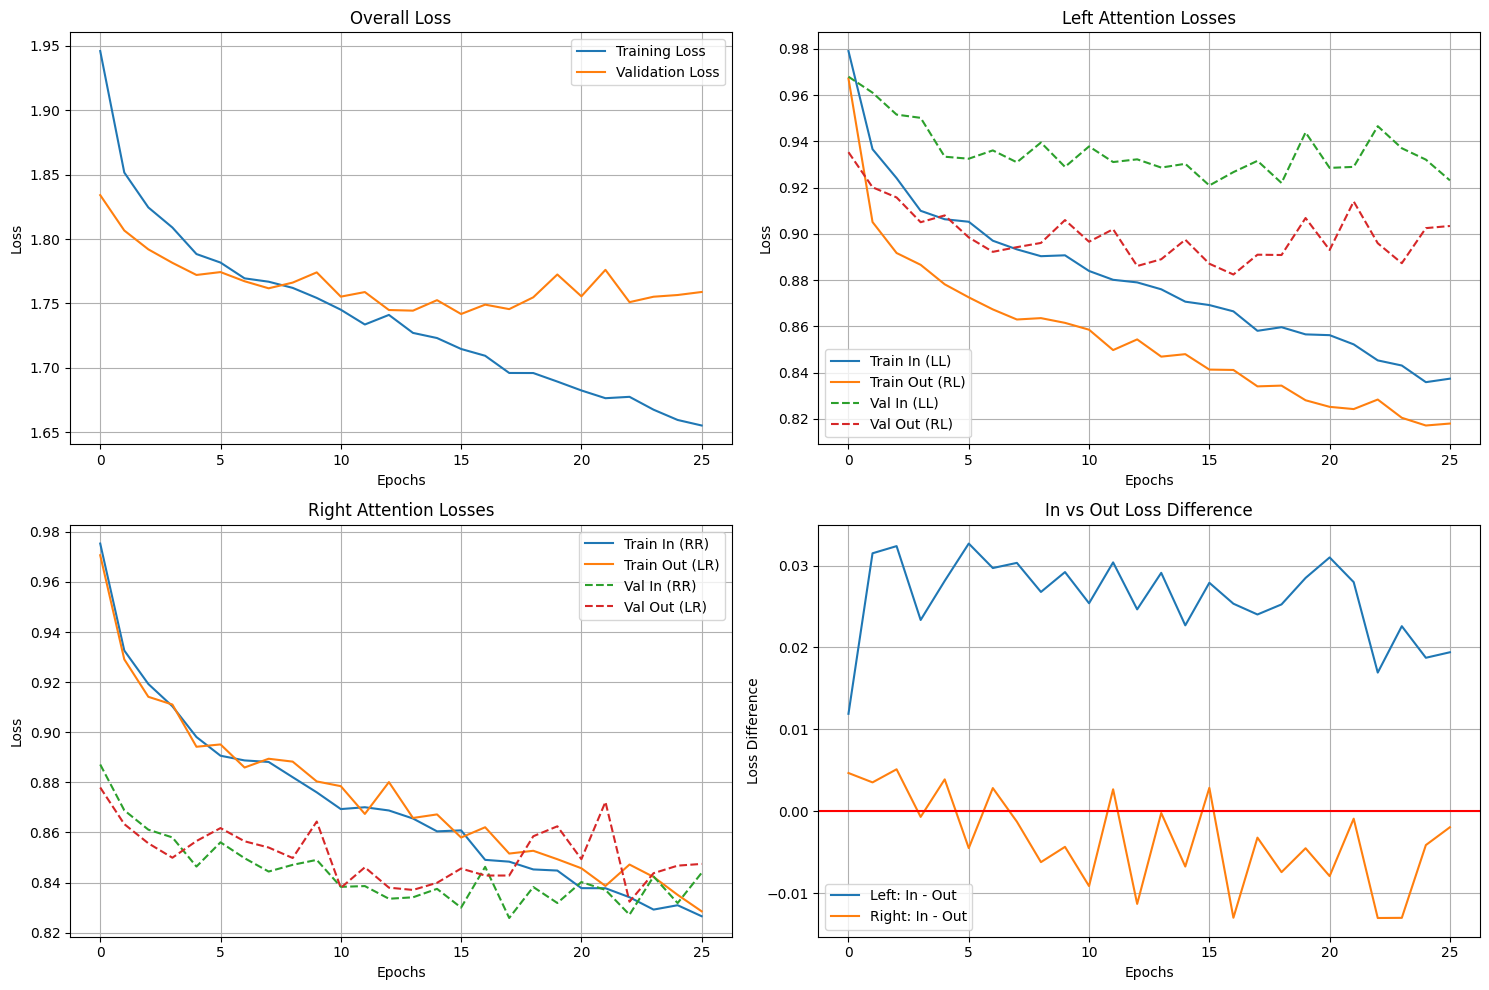

Epoch 25/100 - Train Loss: 1.6552 - Val Loss: 1.7589
Left Attention - In: 0.8373, Out: 0.8179
Right Attention - In: 0.8266, Out: 0.8285


KeyboardInterrupt: 

In [8]:
# Collect the data
l_al, l_ar, r_al, r_ar, a_al, a_ar = collect_data(file_numbers)

# Prepare data for accuracy comparison
train_loaders, val_loaders, test_loaders, norm_params = prepare_accuracy_comparison_data(
    l_al, r_al, l_ar, r_ar, a_al, a_ar, file_numbers, batch_size=32
)

# Get input dimensions from a sample batch
sample_x, _ = next(iter(train_loaders['in_left']))
n_neurons_in = sample_x.shape[2]
# Get number of output timepoints from y shape (should be 250 for your new setup)
sample_y = next(iter(train_loaders['in_left']))[1]
n_timesteps_out = sample_y.shape[1] 
print('Number of input neurons:', n_neurons_in)
print('Number of output timepoints:', n_timesteps_out)

# Initialize the attention-aware LSTM model
attention_model = AttentionLSTM(
    input_dim=n_neurons_in,
    hidden_dim=64,
    attention_dim=64,
    output_dim=n_timesteps_out,  # Now predicts a single output trace per trial
    num_layers=2,
    dropout=0.5
)

# Train the unified model
history = train_unified_model(
    model = attention_model,
    train_loaders = train_loaders,
    val_loaders = val_loaders,
    criterion = nn.MSELoss(),
    epochs = 100,
    lr = 1e-3,
    wd = 1e-4,
    patience = 15
)

# Compare prediction accuracy between in and out conditions
accuracy_results, detailed_metrics = compare_prediction_accuracy(
    model=attention_model,
    test_loaders=test_loaders,
    norm_params=norm_params
)